#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала загрузим все нужные нам библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

Откроим фаил и посмотрим общие данные.

In [2]:
try:
    data = pd.read_csv('C:/Users/Пользователь/OneDrive/Документы/Python/taxi.csv',index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.shape

(26496, 1)

In [4]:
data.index.min()

Timestamp('2018-03-01 00:00:00')

In [5]:
data.index.max()

Timestamp('2018-08-31 23:50:00')

Проверим хронологический порядок индексов.

In [6]:
data.index.is_monotonic

True

Проверим на пропуски.

In [7]:
data.isna().sum()

num_orders    0
dtype: int64

Ресемплируем данные по 1 часу

In [8]:
data = data.resample('1H').sum()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:xlabel='datetime'>

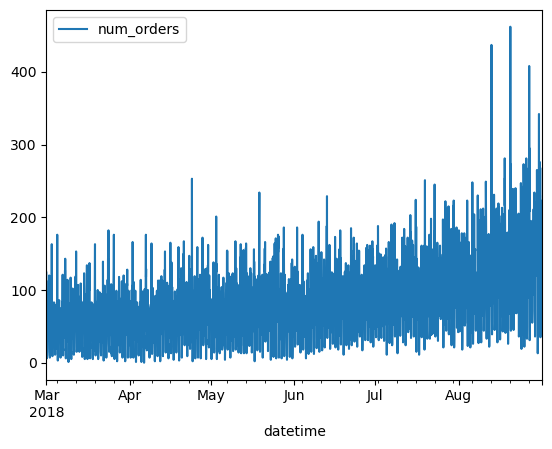

In [10]:
data.plot()

## Анализ

Разложим временной ряд на тренд и сезоную составляющие.

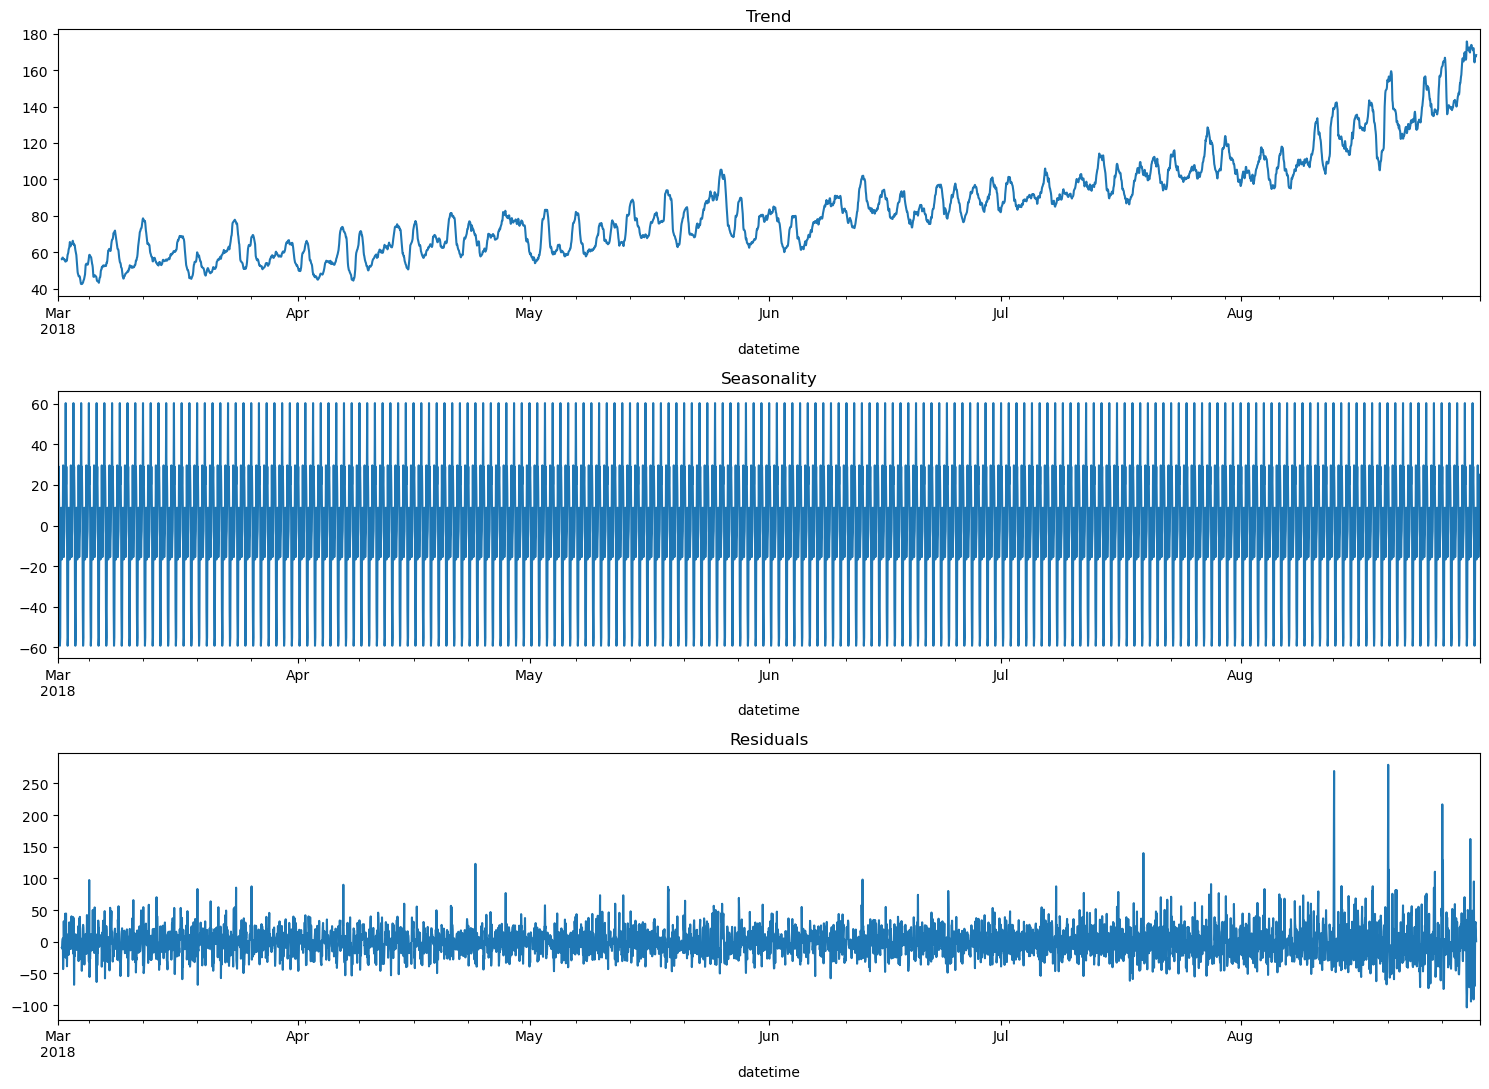

In [11]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 11))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Начиная с июля наблюдается тренд увеличения количества заказов такси.

Посмотрим эти же графики на примере последних 2 дней, что бы оценить спрос на такси не по дням, а по часам.

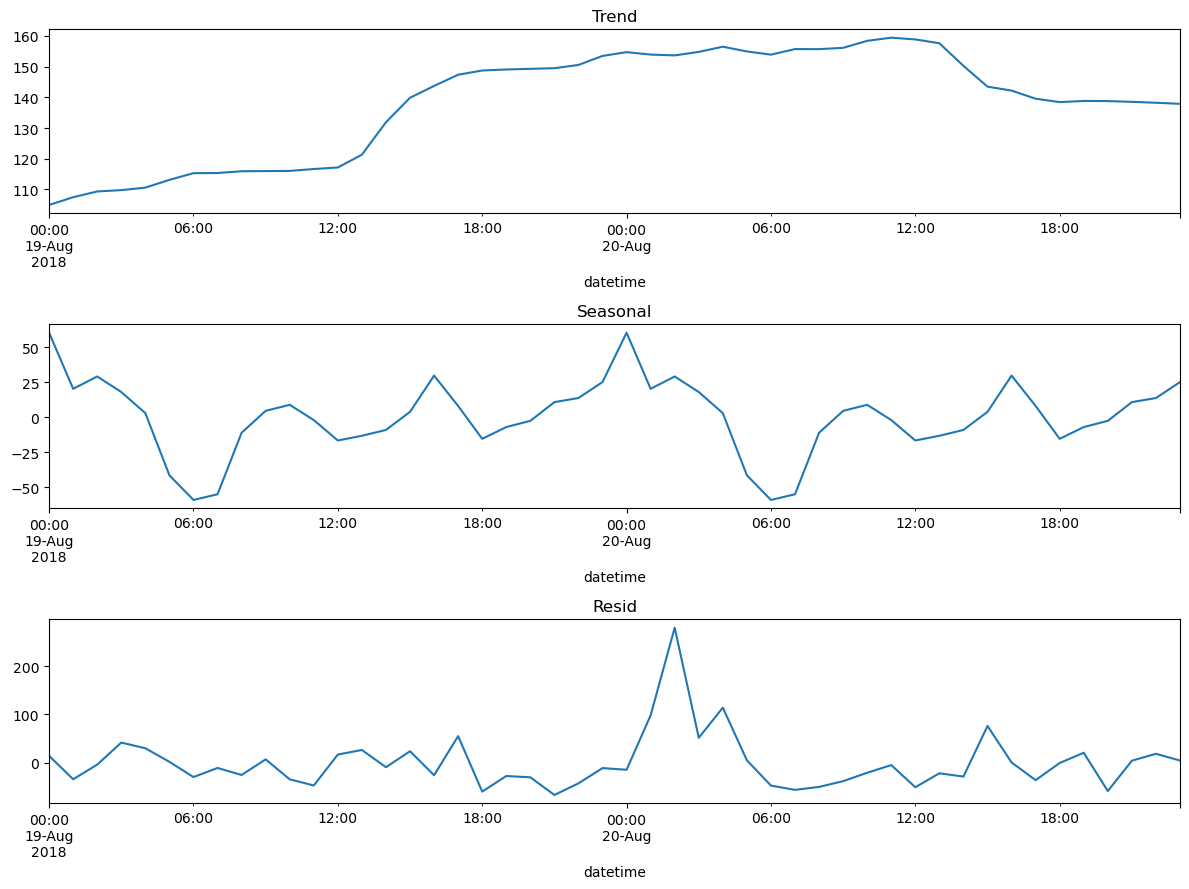

In [12]:
plt.figure(figsize=(12, 9))
plt.subplot(311)

decomposed.trend['2018-08-19':'2018-08-20'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-19':'2018-08-20'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-08-19':'2018-08-20'].plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()


Наибольшим спросом такси пользуется вечером около 17:00 и полночь. А наименьший спрос утром, около 6:00.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Здесь все корректно. Анализ краткий, но главные составляющие мы посмотрели, тренд и сезонности изучили. Можно было бы также прокомментировать остатки.
    
По «остаткам» - это то, что мы не можем объяснить трендом и сезонностью, наше «случайное блуждание». Нужно посмотреть, на всем ли протяжении доля остатков одинаковая? Высокая ли она (тут сложно с первого раза, подскажу - не сильно высокая, модель будет неплохо все предсказывать). А вот если «остатков» к концу графика больше, значит в тестовую выборку попадет чуть больше данных, которые сложно объяснить и на которых модели будет сложнее предсказывать. Поэтому относительно большая (по сравнению с другими задачами машинного обучения) разница между метриками при обучении и исследовании, и между тестовой выборкой, не обязательно будет объясняться только переобучением модели.

    
</div> 

#  Обучение

Создадим Функцию для обозначения признаков.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour']=data.index.hour
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)]= data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Сразу посмотрим на показатель RMSE у медианной модели для проверки наших моделей на адекватность.

Обучим несколько моделей и сравним их по RMSE. Используем GridSearchCV для поиска лучших показателей.

Начнем с RandomForestRegressor.

In [14]:
best_lag_rfr = 0
best_rolling_size_rfr = 0
best_rmse = 85
for lag in range (51, 61, 10):
    for roll in range(1, 11, 10):
        data_features = make_features(data, lag, roll)
        train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state = 12345)
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test = test['num_orders']
        
        forest = RandomForestRegressor()
        tss = TimeSeriesSplit(n_splits = 5)
        forest_params = {'max_depth': range(11, 21, 5)}
        grid = GridSearchCV(forest, 
                            forest_params, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss , 
                            n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse = (-grid.best_score_) ** 0.5 
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag_rfr = lag
            best_rolling_size_rfr = roll
        
            
print('Метрика RMSE:', best_rmse)
params_rfr = grid.best_params_
print('Применяемые параметры:', params_rfr)

Метрика RMSE: 24.74931015673328
Применяемые параметры: {'max_depth': 16}


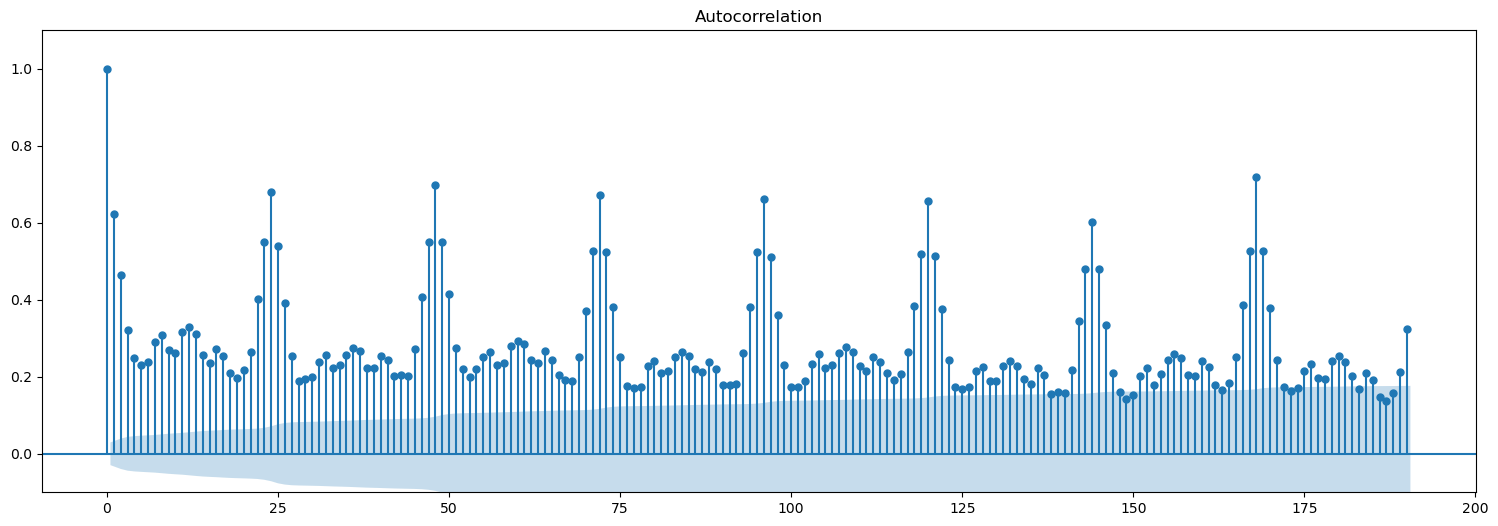

In [15]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


Далее проверим CatBoost.

In [16]:
best_lag_cb = 0
best_rolling_size_cb = 0
best_rmse = 85
for lag in range (1, 11, 10):
    for roll in range(31, 41, 10):
        data_features = make_features(data, lag, roll)
        train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state = 12345)
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test = test['num_orders']
        
        cat = CatBoostRegressor(iterations = 100, verbose = False)
        tss = TimeSeriesSplit(n_splits = 5)
        cat_params = {'learning_rate':[0.1]}
        
        grid = GridSearchCV(cat, 
                            cat_params, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss , 
                            n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse = (-grid.best_score_) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag_cb = lag
            best_rolling_size_cb = roll
                
            
print('Метрика RMSE:', best_rmse)
params_cb = grid.best_params_
print('Применяемые параметры:', params_cb)

Метрика RMSE: 24.42148575282962
Применяемые параметры: {'learning_rate': 0.1}


Разница с RandomForestRegressor не такая большая, но все же показатель получился лучше. 

Теперь проверим модель LightGBM.

In [17]:
best_lag_GBM = 0
best_rolling_size_GBM = 0
best_rmse = 85
for lag in range (1, 11, 10):
    for roll in range(31, 41, 10):
        data_features = make_features(data, lag, roll)
        train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state = 12345)
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test = test['num_orders']
        
        gbm = lgb.LGBMRegressor(random_state=12345)
        tss = TimeSeriesSplit(n_splits = 5)
        gbm_params = {'num_leaves': range(25, 400, 15)}
        
        grid = GridSearchCV(gbm, 
                            gbm_params, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss , 
                            n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse = (-grid.best_score_) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag_cb = lag
            best_rolling_size_cb = roll
                
            
print('Метрика RMSE:', best_rmse)
params_GBM = grid.best_params_
print('Применяемые параметры:', params_GBM)

Метрика RMSE: 24.46159209230676
Применяемые параметры: {'num_leaves': 25}


Хорошая попытка, но до CatBoost немного не хватило.

Все модели прошли проверку на адекватность и показатели очень схожие результаты, но немного лучше показала себя модель CatBoost с показателями RMSE - 24.61

## Тестирование

Проведем финальные тесты, определим RSME на тестовых данных

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
    
features_train = train.drop('num_orders',axis=1)
features_test = test.drop('num_orders',axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [19]:
model = RandomForestRegressor(max_depth=16, random_state=1234)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
rmse

42.68704441956596

In [20]:
model2 = CatBoostRegressor(iterations = 100, verbose = False, learning_rate=0.1)
model2.fit(features_train, target_train)
predictions = model2.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
rmse

41.11289854543664

In [21]:
model3 = lgb.LGBMRegressor(num_leaves = 25, random_state=12345)
model3.fit(features_train, target_train)
predictions = model3.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
rmse

39.919953752321646

Лучше всего на тестовой выборке показал себя CatBoos* с показателем RMSE = 40.52

## Итог

Проанализировав даднные  сразу видно прямые зависимость колличества заказов от даты и времени.

Все три протестированных нами модели показывают результат с отклонением меньше 48.С небольшим отрывом лучший результат метрики RMSE показала модель CatBoost.